<a href="https://colab.research.google.com/github/zhongjie-wu/579project/blob/main/COMP_579_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 579 Final Project: Multi-Agent Reinforcement Learning

In [1]:
# download libraries
! pip install pettingzoo[mpe]

zsh:1: no matches found: pettingzoo[mpe]


In [2]:
# import necessary libraries
from pettingzoo.mpe import simple_speaker_listener_v3, simple_reference_v2, simple_world_comm_v2
import numpy as np
import matplotlib.pyplot as plt

## Individual Q-learning (Simple Speaker Listener)

In [3]:
# Helper methods
def listener_bin_init(bounds = [(-2, 2),(-4, 4)], step_size=0.05):
    '''
    (x_vel, y_vel, land1_x, land1_y, land2_x, land2_y, land3_x, land3_y, spearker_cmd0, spearker_cmd1, spearker_cmd2)
    '''
    discretized_state = [0 for i in range(8)]
    for i in range(2):
        discretized_state[i] = np.linspace(bounds[0][0], bounds[0][1], int((bounds[0][1] - bounds[0][0])/step_size) + 1)
        
    for i in range(2, 8):
        discretized_state[i] = np.linspace(bounds[1][0], bounds[1][1], int((bounds[1][1] - bounds[1][0])/step_size) + 1)

    return tuple(discretized_state)

def listener_encode_state(observation, discretized_state=listener_bin_init()):
    # encode x,y velocity
    index = np.zeros(8)
    result = []
    for i in range(8):
        idx = np.digitize([observation[i]], discretized_state[i])
        index[i] = idx - 1
        if i < 2:
            result += [1 if i == idx else 0 for i in range(81)]
        else:
            result += [1 if i == idx else 0 for i in range(161)]
    for i in range(8, 11):
        result.append(observation[i])
    return np.array(result)

def speaker_encode_state(observation):
    return np.array([float(i == np.argmax(observation)) for i in range(len(observation))])

def weight_init(size: tuple):
    return np.random.uniform(-0.001, 0.001, size)

def eps_greedy_act_selection(epsilon, w, state):
    num_choices = w.shape[0]
    if np.random.random() < epsilon:
        return np.random.randint(0, num_choices)
    else:
        result = np.dot(w, state)
        return np.argmax(result)

In [31]:
# Returns a initialized weight vector with 0
def q_learning_sl(alpha, gamma, epsilon, num_episode, env):
    w_speaker = weight_init((3, 3))
    w_listener = weight_init((5, 1131))
    AGENT_NAMES = ['speaker_0', 'listener_0']
    all_rewards = {agent_name:[] for agent_name in AGENT_NAMES}
    R_speaker = 0
    R_listener = 0
    
    for i in range(num_episode):
        env.reset()
        S_speaker = env.observe('speaker_0')
        # encode speaker state
        phi_speaker = speaker_encode_state(S_speaker)
        
        S_listener = env.observe('listener_0')
        # encode listener state
        phi_listener = listener_encode_state(S_listener)        
        
        S_next_speaker = None
        phi_next_speaker = None
        
        S_next_listener = None
        phi_next_listener = None
        
        for agent in env.agent_iter():
            if agent == 'speaker_0':
                if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue
                
                A = eps_greedy_act_selection(epsilon, w_speaker, phi_speaker)
                # A = env.action_space(agent).sample()
                
                env.step(A) 
                _, R, termination, truncation, info = env.last()
                R_speaker = R
                
                S_next_speaker = env.observe(agent)
                phi_next_speaker = speaker_encode_state(S_next_speaker)
                q_S_w = np.dot(w_speaker, phi_speaker)
                q_S_A_w = q_S_w[A]
                grad_q_S_A_w = phi_speaker

                if termination or truncation:
                    w_speaker[A] = w_speaker[A] + alpha * (R - q_S_A_w) * grad_q_S_A_w
                    continue

                max_q_S_A_w = np.max(np.dot(w_speaker, phi_next_speaker))
                w_speaker[A] = w_speaker[A] + alpha * (R + gamma*max_q_S_A_w - q_S_A_w) * grad_q_S_A_w
                phi_speaker = phi_next_speaker
                
                # for debug usage
                S_speaker = S_next_speaker
                
            else:
                if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue
                
                A = eps_greedy_act_selection(epsilon, w_listener, phi_listener)
                # A = env.action_space(agent).sample()

                env.step(A)

                _, R, termination, truncation, info = env.last()
                R_listener = R

                S_next_listener = env.observe(agent)
                phi_next_listener = listener_encode_state(S_next_listener)

                q_S_w = np.dot(w_listener, phi_listener)
                q_S_A_w = q_S_w[A]
                grad_q_S_A_w = phi_listener

                if termination or truncation:
                    w_listener[A] = w_listener[A] + alpha * (R - q_S_A_w) * grad_q_S_A_w
                    continue

                max_q_S_A_w = np.max(np.dot(w_listener, phi_next_listener))
                w_listener[A] = w_listener[A] + alpha * (R + gamma*max_q_S_A_w - q_S_A_w) * grad_q_S_A_w
                phi_listener = phi_next_listener
                
                # for debug usage
                S_listener = S_next_listener

        all_rewards['speaker_0'].append(R_speaker)
        all_rewards['listener_0'].append(R_listener)
        
    return w_speaker, w_listener, all_rewards

## Random Policy

In [5]:
# Returns a initialized weight vector with 0
def rand_sl(alpha, gamma, epsilon, num_episode, env):
    w_speaker = weight_init((3, 3))
    w_listener = weight_init((5, 1131))
    R = 0
    
    for i in range(num_episode):
        env.reset()
        S_speaker = env.observe('speaker_0')
        # encode speaker state
        phi_speaker = speaker_encode_state(S_speaker)
        
        S_listener = env.observe('listener_0')
        # encode listener state
        phi_listener = listener_encode_state(S_listener)        
        
        S_next_speaker = None
        phi_next_speaker = None
        
        S_next_listener = None
        phi_next_listener = None
        
        for agent in env.agent_iter():
            if agent == 'speaker_0':
                if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue
                
                # A = eps_greedy_act_selection(epsilon, w_speaker, phi_speaker)
                A = env.action_space(agent).sample()
                
                env.step(A) 
                _, R, termination, truncation, info = env.last()
                
                S_next_speaker = env.observe(agent)
                #phi_next_speaker = speaker_encode_state(S_next_speaker)
                #q_S_w = np.dot(w_speaker, phi_speaker)
                #q_S_A_w = q_S_w[A]
                #grad_q_S_A_w = phi_speaker

                if termination or truncation:
                    #w_speaker[A] = w_speaker[A] + alpha * (R - q_S_A_w) * grad_q_S_A_w
                    continue

                #max_q_S_A_w = np.max(np.dot(w_speaker, phi_next_speaker))
                #w_speaker[A] = w_speaker[A] + alpha * (R + gamma*max_q_S_A_w - q_S_A_w) * grad_q_S_A_w
                #phi_speaker = phi_next_speaker
                
                # for debug usage
                S_speaker = S_next_speaker
                
            else:
                if env.truncations[agent] == True or env.terminations[agent] == True:
                    env.step(None)
                    continue
                
                # A = eps_greedy_act_selection(epsilon, w_listener, phi_listener)
                A = env.action_space(agent).sample()

                env.step(A)

                _, R, termination, truncation, info = env.last()

                S_next_listener = env.observe(agent)
                #phi_next_listener = listener_encode_state(S_next_listener)

                #q_S_w = np.dot(w_listener, phi_listener)
                #q_S_A_w = q_S_w[A]
                #grad_q_S_A_w = phi_listener

                if termination or truncation:
                    #w_listener[A] = w_listener[A] + alpha * (R - q_S_A_w) * grad_q_S_A_w
                    continue

                #max_q_S_A_w = np.max(np.dot(w_listener, phi_next_listener))
                #w_listener[A] = w_listener[A] + alpha * (R + gamma*max_q_S_A_w - q_S_A_w) * grad_q_S_A_w
                #phi_listener = phi_next_listener
                
                # for debug usage
                S_listener = S_next_listener
    
        
    return R

## Testing Environments

### Simple Speaker Listener

In [32]:
env = simple_speaker_listener_v3.env(max_cycles=25, continuous_actions=False)
_, _, ALL_REWARDS = q_learning_sl(0.001, 0.99, 0.2, 1000, env)

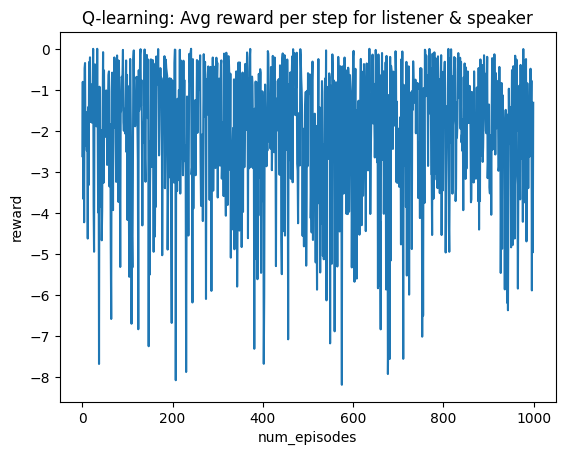

In [33]:
# this graphs the last reward for each episode
plt.plot(range(1000), ALL_REWARDS['listener_0'])
plt.title('Q-learning: Avg reward per step for listener & speaker')
plt.xlabel('num_episodes')
plt.ylabel('reward')
plt.show()